In [82]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [83]:
!rm bank*
!ls -la

total 1336
drwxr-xr-x  11 vladflore  staff     352 Oct 22 01:15 .
drwxr-xr-x   6 vladflore  staff     192 Sep 16 18:03 ..
drwxr-xr-x  14 vladflore  staff     448 Oct 22 01:14 .git
-rw-r--r--   1 vladflore  staff      19 Sep 16 21:55 .gitignore
drwxr-xr-x   7 vladflore  staff     224 Oct 20 00:04 .ipynb_checkpoints
drwxr-xr-x   6 vladflore  staff     192 Oct  7 12:06 .mypy_cache
-rw-r--r--   1 vladflore  staff    5736 Sep 25 23:01 01-intro-hw.ipynb
-rw-r--r--   1 vladflore  staff  114677 Oct 20 15:18 02-regression-hw.ipynb
-rw-r--r--   1 vladflore  staff  247713 Oct 20 15:18 03-classification-hw.ipynb
-rw-r--r--   1 vladflore  staff  299847 Oct 22 01:14 04-classification-evaluation-metrics-hw.ipynb
-rw-r--r--   1 vladflore  staff      40 Sep 16 18:06 README.md


In [84]:
zip_url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
!wget $zip_url

--2024-10-22 01:15:31--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999.85K   888KB/s    in 1.1s    

2024-10-22 01:15:33 (888 KB/s) - ‘bank+marketing.zip’ saved [1023843]



In [85]:
!unzip bank+marketing.zip

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     


In [86]:
!unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [87]:
data = 'bank-full.csv'
df = pd.read_csv(data, sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [88]:
for col in df.columns.to_list():
    print(col)
    print()
    print(df[col].unique())
    print()

age

[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]

job

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

marital

['married' 'single' 'divorced']

education

['tertiary' 'secondary' 'unknown' 'primary']

default

['no' 'yes']

balance

[ 2143    29     2 ...  8205 14204 16353]

housing

['yes' 'no']

loan

['no' 'yes']

contact

['unknown' 'cellular' 'telephone']

day

[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]

month

['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

duration

[ 261  151   76 ... 1298 1246 1556]

campaign

[ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 3

In [89]:
features_string = """
age,
job,
marital,
education,
balance,
housing,
contact,
day,
month,
duration,
campaign,
pdays,
previous,
poutcome,
y
"""
features = [f.strip() for f in features_string.split(',')]

In [90]:
df.shape

(45211, 17)

In [91]:
df = df[features]
df.shape

(45211, 15)

In [92]:
df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [93]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [94]:
df.y = (df.y == 'yes').astype(int)
df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,0


In [95]:
df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [96]:
numerical_features = set(df.select_dtypes(include='int64').columns.to_list())
categorical_features = set(df.columns.to_list()).difference(numerical_features)
numerical_features, categorical_features

({'age', 'balance', 'campaign', 'day', 'duration', 'pdays', 'previous', 'y'},
 {'contact', 'education', 'housing', 'job', 'marital', 'month', 'poutcome'})

In [97]:
# df_train, df_remaining = train_test_split(df, test_size=0.4, random_state=1)

# df_val, df_test = train_test_split(df_remaining, test_size=0.5, random_state=1)

# 80%          20% 
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
# 60%     20% 
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df.shape[0], df_train.shape[0] + df_val.shape[0] + df_test.shape[0]

(45211, 45211)

In [98]:
df_train = df_train.reset_index(drop=True)
df_train

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown,0
1,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure,0
2,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown,0
3,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown,1
4,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27121,32,technician,single,tertiary,195,yes,cellular,22,aug,239,2,-1,0,unknown,0
27122,52,self-employed,married,secondary,3720,no,cellular,20,nov,114,2,-1,0,unknown,0
27123,52,blue-collar,married,secondary,289,yes,unknown,21,may,45,13,-1,0,unknown,0
27124,32,management,married,tertiary,312,no,cellular,11,aug,67,4,-1,0,unknown,0


In [99]:
df_val = df_val.reset_index(drop=True)
df_val

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,57,blue-collar,married,primary,856,no,cellular,11,aug,194,6,-1,0,unknown,0
1,50,housemaid,married,primary,0,no,cellular,27,aug,52,3,-1,0,unknown,0
2,30,management,single,tertiary,5956,yes,unknown,8,may,255,1,-1,0,unknown,0
3,33,blue-collar,married,secondary,312,yes,unknown,4,jun,151,2,-1,0,unknown,0
4,54,technician,single,secondary,198,yes,cellular,17,nov,120,1,171,2,failure,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9037,54,technician,married,secondary,-939,yes,unknown,29,may,202,1,-1,0,unknown,0
9038,37,management,married,tertiary,8821,yes,cellular,14,may,167,1,-1,0,unknown,0
9039,62,unknown,married,secondary,367,no,telephone,7,sep,221,1,189,5,failure,0
9040,44,blue-collar,married,primary,1432,yes,unknown,27,may,63,9,-1,0,unknown,0


In [100]:
df_test = df_test.reset_index(drop=True)
df_test

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,blue-collar,married,primary,2519,yes,unknown,15,may,262,4,-1,0,unknown,0
1,37,technician,married,secondary,2209,no,unknown,20,jun,167,2,-1,0,unknown,0
2,32,admin.,married,secondary,923,yes,cellular,17,apr,819,4,-1,0,unknown,0
3,53,blue-collar,married,primary,306,no,cellular,28,jul,388,3,181,1,success,1
4,32,technician,single,tertiary,257,yes,unknown,2,jun,183,5,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9038,56,housemaid,married,primary,0,no,cellular,26,aug,102,2,-1,0,unknown,0
9039,33,services,single,secondary,3910,yes,cellular,19,nov,676,2,-1,0,unknown,0
9040,44,unknown,married,unknown,1317,no,telephone,31,jul,444,6,-1,0,unknown,0
9041,31,management,single,tertiary,305,yes,unknown,28,may,297,14,-1,0,unknown,0


In [101]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [102]:
del df_train['y']
del df_val['y']
del df_test['y']

In [103]:
df_train

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown
1,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure
2,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown
3,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown
4,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27121,32,technician,single,tertiary,195,yes,cellular,22,aug,239,2,-1,0,unknown
27122,52,self-employed,married,secondary,3720,no,cellular,20,nov,114,2,-1,0,unknown
27123,52,blue-collar,married,secondary,289,yes,unknown,21,may,45,13,-1,0,unknown
27124,32,management,married,tertiary,312,no,cellular,11,aug,67,4,-1,0,unknown


In [104]:
df_val

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,57,blue-collar,married,primary,856,no,cellular,11,aug,194,6,-1,0,unknown
1,50,housemaid,married,primary,0,no,cellular,27,aug,52,3,-1,0,unknown
2,30,management,single,tertiary,5956,yes,unknown,8,may,255,1,-1,0,unknown
3,33,blue-collar,married,secondary,312,yes,unknown,4,jun,151,2,-1,0,unknown
4,54,technician,single,secondary,198,yes,cellular,17,nov,120,1,171,2,failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9037,54,technician,married,secondary,-939,yes,unknown,29,may,202,1,-1,0,unknown
9038,37,management,married,tertiary,8821,yes,cellular,14,may,167,1,-1,0,unknown
9039,62,unknown,married,secondary,367,no,telephone,7,sep,221,1,189,5,failure
9040,44,blue-collar,married,primary,1432,yes,unknown,27,may,63,9,-1,0,unknown


In [105]:
df_test

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,42,blue-collar,married,primary,2519,yes,unknown,15,may,262,4,-1,0,unknown
1,37,technician,married,secondary,2209,no,unknown,20,jun,167,2,-1,0,unknown
2,32,admin.,married,secondary,923,yes,cellular,17,apr,819,4,-1,0,unknown
3,53,blue-collar,married,primary,306,no,cellular,28,jul,388,3,181,1,success
4,32,technician,single,tertiary,257,yes,unknown,2,jun,183,5,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9038,56,housemaid,married,primary,0,no,cellular,26,aug,102,2,-1,0,unknown
9039,33,services,single,secondary,3910,yes,cellular,19,nov,676,2,-1,0,unknown
9040,44,unknown,married,unknown,1317,no,telephone,31,jul,444,6,-1,0,unknown
9041,31,management,single,tertiary,305,yes,unknown,28,may,297,14,-1,0,unknown


In [106]:
numerical_features.difference_update({'y'})
numerical_features = list(numerical_features)
categorical_features = list(categorical_features)
all_features = numerical_features + categorical_features

In [107]:
def train(df_train, y_train, C=1.0):
    dict_train = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    # dv.fit(dict_train)
    # X_train = dv.transform(dict_train)
    X_train = dv.fit_transform(dict_train)
    # model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return model

In [108]:
def predict(model, df_val):
    dict_val = df_val.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(dict_val)
    X_val = dv.transform(dict_val)
    return model.predict_proba(X_val)[:, 1]

In [109]:
def accuracy(y_pred, y_val):
    y_decission = y_pred >= 0.5
    # return round((y_val == y_decission).mean(), 2)
    return (y_val == y_decission).mean()

In [110]:
m = train(df_train=df_train, y_train=y_train)
y_pred = predict(model=m, df_val=df_val)
# all_features_accuracy = accuracy(y_pred=y_pred, y_val=y_val)
# all_features_accuracy

In [111]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
round(roc_auc_score(y_val, y_pred), 3)

0.9

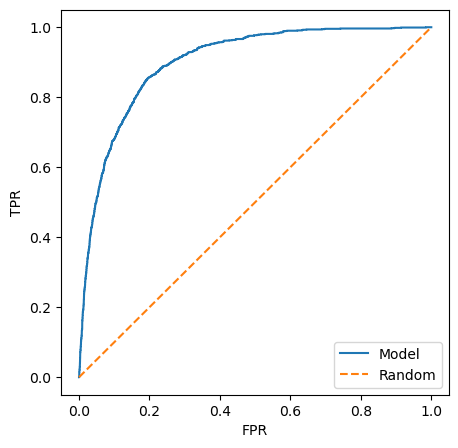

In [112]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [113]:
def calculate_feature_importance(target, feature):
    fpr, tpr, thresholds = roc_curve(target, feature)
    auc_val = auc(fpr, tpr)
    if auc_val < 0.5:
        auc_val = roc_auc_score(target, -feature)
    return auc_val, fpr, tpr

,Feature,AUC
0,duration,0.814700
1,previous,0.598565
4,pdays,0.590128
2,balance,0.588831
6,campaign,0.571454
3,day,0.525958
5,age,0.512186


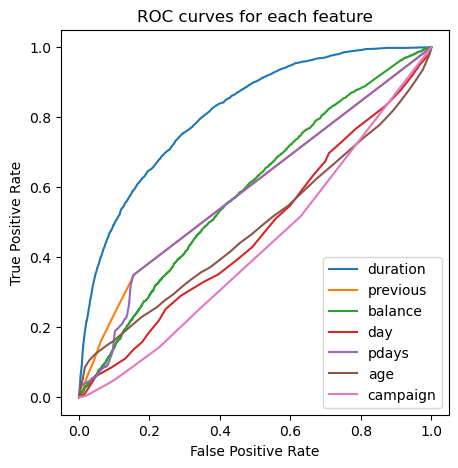

In [114]:
plt.figure(figsize=(5, 5))

auc_dict = {}
for feature in numerical_features:
    auc_val, fpr, tpr = calculate_feature_importance(y_train, df_train[feature])
    auc_dict[feature] = auc_val
    plt.plot(fpr, tpr, label=f'{feature}')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for each feature')

auc_df = pd.DataFrame(list(auc_dict.items()), columns=['Feature', 'AUC']).sort_values(by='AUC', ascending=False)
display.display(auc_df)

In [115]:
thresholds = np.arange(0.0, 1.0, 0.01)
actual_pos = (y_val == 1)
actual_neg = (y_val == 0)
precisions = []
recalls = []
for t in thresholds:
    predict_pos = (y_pred >= t)
    predict_neg = (y_pred < t)
    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()
    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    precisions.append(p)
    recalls.append(r)

In [116]:
diffs = np.abs(np.array(precisions) - np.array(recalls))
min_diff_idx = np.argmin(diffs)
t_value = thresholds[min_diff_idx]

p_value = precisions[min_diff_idx]
r_value = recalls[min_diff_idx]
print(f'{t_value=}, {p_value=}, {r_value=}')

t_value=0.26, p_value=0.5561545372866128, r_value=0.563752276867031


Text(0.5, 1.0, 'Precision - Recall vs. Threshold')

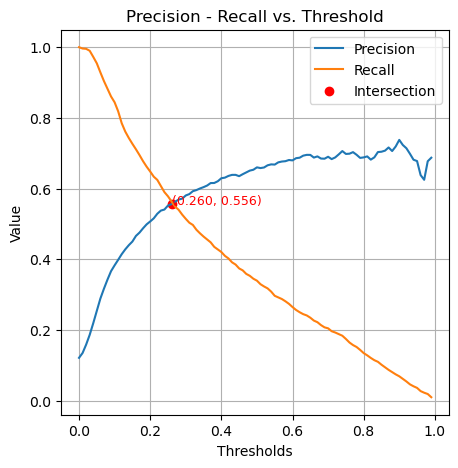

In [117]:
plt.figure(figsize=(5, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.scatter(t_value, p_value, color='red', label='Intersection')
plt.text(t_value, p_value, f'({t_value:.3f}, {p_value:.3f})', color = 'red', fontsize=9)
plt.grid()
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Value')
plt.title('Precision - Recall vs. Threshold')

In [118]:
f1 = 2 * (np.array(precisions) * np.array(recalls)) / (np.array(precisions) + np.array(recalls))
idx_max_f1 = np.argmax(f1)
t = thresholds[idx_max_f1]
f1_score = f1[idx_max_f1]
print(f'{f1_score=}')

f1_score=0.5728601252609603


Text(0.5, 1.0, 'F1 Score')

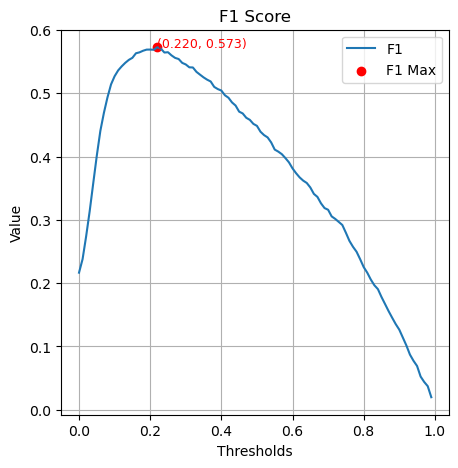

In [119]:
plt.figure(figsize=(5, 5))
plt.plot(thresholds, f1, label='F1')
plt.scatter(t, f1_score, color='red', label='F1 Max')
plt.text(t, f1_score, f'({t:.3f}, {f1_score:.3f})', color = 'red', fontsize=9)
plt.grid()
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Value')
plt.title('F1 Score')

In [120]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.y.values
    y_val = df_val.y.values
    df_train = df_train[all_features]
    df_val = df_val[all_features]
    m = train(df_train=df_train, y_train=y_train)
    y_pred = predict(model=m, df_val=df_val)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

mean = np.mean(scores)
std_dev = np.std(scores)
print(f'{mean=:0.3f}, {std_dev=:0.3f}')

mean=0.906, std_dev=0.006


In [121]:
n_splits = 5
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_train.y.values
        y_val = df_val.y.values
        df_train = df_train[all_features]
        df_val = df_val[all_features]
        m = train(df_train=df_train, y_train=y_train, C=C)
        y_pred = predict(model=m, df_val=df_val)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    mean = np.mean(scores)
    std_dev = np.std(scores)
    print(f'{C=}, {mean=:0.3f}, {std_dev=:0.3f}')

C=1e-06, mean=0.701, std_dev=0.009
C=0.001, mean=0.861, std_dev=0.007
C=1, mean=0.906, std_dev=0.006
